In [34]:
from citation_index.core.extractors import ExtractorFactory
import pandas as pd
import json
from Levenshtein import ratio as levenshtein_ratio

# EXCITE data

In [66]:
def get_sample_data(pdf_df, references_data, n_samples=5):
    """Display sample data for verification"""
    print(f"\n=== SAMPLE PDF DATA ===")
    if not pdf_df.empty:
        print(pdf_df.sample(n_samples).to_string(index=False))
    
    print(f"\n=== SAMPLE REFERENCES DATA ===")
    if references_data:
        sample_keys = list(references_data.keys())[:n_samples]
        for i, file_id in enumerate(sample_keys):
            ref_data = references_data[file_id]
            print(f"Paper {i+1} (ID: {file_id}):")
            print(f"  Number of references: {len(ref_data['references'])}")
            print(f"  First few references:")
            for j, ref in enumerate(ref_data['references'][:3]):
                print(f"    {j+1}. {ref}")
            if len(ref_data['references']) > 3:
                print(f"    ... and {len(ref_data['references']) - 3} more")
            print()


pdf_df = pd.read_csv("../../EXgoldstandard/Goldstandard_EXparser/pdf_files_info.csv")
references_data = json.load(open("../../EXgoldstandard/Goldstandard_EXparser/all_references.json", "r", encoding="utf-8"))

total_references = sum(len(data["references"]) for data in references_data.values())
print('Total references:', total_references)

Total references: 10171


In [14]:
get_sample_data(pdf_df, references_data)


=== SAMPLE PDF DATA ===
 file_id  filename  class lang                                                                                                                       file_path  page_count
   34237 34237.pdf      1   en EXgoldstandard/Goldstandard_EXparser/2-English_papers/1-English_papers(with_reference_section_at_end_of_paper)/1-pdfs/34237.pdf          13
   34793 34793.pdf      1   de   EXgoldstandard/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_section_at_end_of_paper)/1-pdfs/34793.pdf          14
   22077 22077.pdf      1   de   EXgoldstandard/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_section_at_end_of_paper)/1-pdfs/22077.pdf          64
   18291 18291.pdf      1   de   EXgoldstandard/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_section_at_end_of_paper)/1-pdfs/18291.pdf          12
   38850 38850.pdf      1   de   EXgoldstandard/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_sec

<Axes: ylabel='Frequency'>

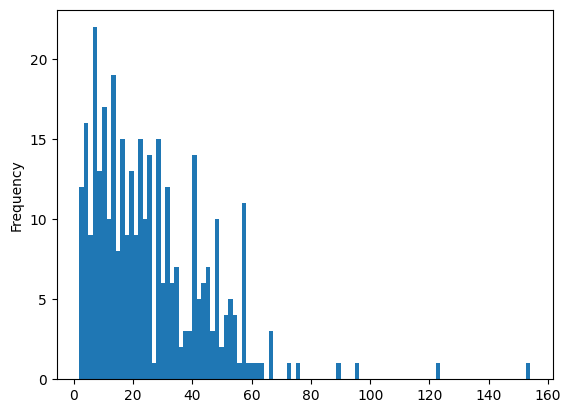

In [15]:
# add reference_count to pdf_df
pdf_df['reference_count'] = pdf_df['file_id'].map(lambda x: len(references_data[str(x)]['references']))
pdf_df['reference_count'].plot(kind='hist', bins=100)


<Axes: ylabel='Frequency'>

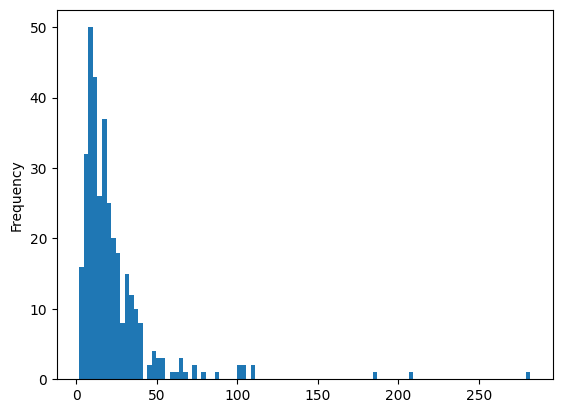

In [16]:
pdf_df['page_count'].plot(kind='hist', bins=100)

In [4]:
REFERENCE_EXTRACTION_PROMPT_SYS = """You are an expert in scholarly references and citations. You help the user to extract citation data from scientific works."""

REFERENCE_EXTRACTION_PROMPT_USER = """
Extract all references from the given text. Output each reference as plain text, one reference per line. Only output the reference text, nothing else. Do not include any explanations, numbering, or additional formatting.

TEXT: <<<{input_text}>>>

## Example Usage
**Input Text:**
This paper builds on previous work (Smith et al., 2020; Jones, 2019). According to recent studies...

References:
1. Smith, J., Brown, A., & Wilson, C. (2020). Machine learning approaches in natural language processing. Journal of AI Research, 15(3), 245-267.
2. Jones, M. (2019). Deep learning fundamentals. MIT Press.
3. Davis, R., & Lee, S. (2021). Neural networks and their applications. Nature Machine Intelligence, 3(2), 112-125.

**Expected Output:**
Smith, J., Brown, A., & Wilson, C. (2020). Machine learning approaches in natural language processing. Journal of AI Research, 15(3), 245-267.
Jones, M. (2019). Deep learning fundamentals. MIT Press.
Davis, R., & Lee, S. (2021). Neural networks and their applications. Nature Machine Intelligence, 3(2), 112-125.
"""

In [62]:
from openai import OpenAI

endpoint = 'https://api.deepseek.com/v1'
model = 'deepseek-chat'
api_key = 'sk-282f6b9a54b64bd98bfcd85c0c8f5aab' # deepseek

client = OpenAI(
    api_key=api_key,
    base_url=endpoint,
)

filepath = '../../EXgoldstandard/Goldstandard_EXparser/all_pdfs/1181.pdf'

extractor = ExtractorFactory.create("pymupdf")
result = extractor.extract(filepath)


response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": REFERENCE_EXTRACTION_PROMPT_SYS},
        {"role": "user", "content": REFERENCE_EXTRACTION_PROMPT_USER.format(input_text=result)}
    ]
)

print(response.choices[0].message.content)

Here are the extracted references from the given text:

Aron, Raymond/Dominique Schnapper (1988): Power, modernity, and sociology : selected sociological writings. Aldershot, Hants, England Brookfield, Vt., USA: E. Elgar ;
Collins, Harry (2004): Gravity's shadow : the search for gravitational waves. Chicago: University of Chicago Press.
Collins, Harry M. (1981): Stages in the Empirical Programme of Relativism. In: Social Studies of Science, 11 S. 3-10.
Collins, Harry M. (1983): An Empirical Relativist Programme in the Sociology of Scientific Knowledge. In: K.D. Knorr-Cetina/M. Mulkay (Hrsg.): Science observed. Perspectives on the social study of science. London. Sage: S: 85-113
Collins, Harry M. (1985): Changing order : replication and induction in scientific practice, London u.a.: Sage.
Collins, Harry/Trevor Pinch (1999): Golem der Forschung (Der). Wie unsere Wissenschaft die Natur erfindet. Berlin: Berlin Verlag.
Dosi, Giovanni (1982): Technological Paradigms and Technological Trajec

In [60]:
references_data['1181']['references']

['Aron, Raymond/Dominique Schnapper (1988): Power, modernity, and sociology : selected sociological writings. Aldershot, Hants, England Brookfield, Vt., USA: E. Elgar ;',
 "Collins, Harry (2004): Gravity's shadow : the search for gravitational waves. Chicago: University of Chicago Press.",
 'Collins, Harry M. (1981): Stages in the Empirical Programme of Relativism. In: Social Studies of Science, 11 S. 3-10.',
 'Collins, Harry M. (1983): An Empirical Relativist Programme in the Sociology of Scientific Knowledge. In: K.D. Knorr-Cetina/M. Mulkay (Hrsg.): Science observed. Perspectives on the social study of science. London. Sage: S: 85-113',
 'Collins, Harry M. (1985): Changing order : replication and induction in scientific practice, London u.a.: Sage.',
 'Collins, Harry/Trevor Pinch (1999): Golem der Forschung (Der). Wie unsere Wissenschaft die Natur erfindet. Berlin: Berlin Verlag.',
 'Dosi, Giovanni (1982): Technological Paradigms and Technological Trajectories. A Suggested Interpreta

In [63]:
import numpy as np
from scipy.optimize import linear_sum_assignment


def calculate_matrix(references_data, response_list):
    """
    Calculate Precision, Recall, F1 and Levenshtein ratio for PDF reference extraction.
    
    Args:
        references_data: List of ground truth references (strings)
        response_list: List of extracted references (strings)
    
    Returns:
        Dict containing precision, recall, f1_score, and avg_levenshtein_ratio
    """
    
    def normalize_text(text):
        """Basic text normalization"""
        if not isinstance(text, str):
            text = str(text)
        return text.strip()
    
    # Normalize inputs and remove empty strings
    gt_refs = [normalize_text(ref) for ref in references_data if normalize_text(ref)]
    pred_refs = [normalize_text(ref) for ref in response_list if normalize_text(ref)]
    
    n_gt = len(gt_refs)
    n_pred = len(pred_refs)
    
    # Handle edge cases
    if n_gt == 0 and n_pred == 0:
        return {
            'precision': 1.0,
            'recall': 1.0,
            'f1_score': 1.0,
            'avg_levenshtein_ratio': 1.0
        }
    
    if n_gt == 0:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0,
            'avg_levenshtein_ratio': 0.0
        }
    
    if n_pred == 0:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0,
            'avg_levenshtein_ratio': 0.0
        }
    
    # Create similarity matrix (higher values = better matches)
    similarity_matrix = np.zeros((n_gt, n_pred))
    
    for i, gt_ref in enumerate(gt_refs):
        for j, pred_ref in enumerate(pred_refs):
            similarity_matrix[i, j] = levenshtein_ratio(gt_ref, pred_ref)
    
    # Convert similarity to cost matrix for Hungarian algorithm (lower costs = better matches)
    cost_matrix = 1.0 - similarity_matrix
    
    # Find optimal assignment using Hungarian algorithm (minimize total cost)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Define similarity threshold
    SIMILARITY_THRESHOLD = 0.8  # Accept matches with similarity >= 0.8
    
    matched_pairs = 0
    total_similarity = 0
    
    for i, j in zip(row_indices, col_indices):
        similarity = similarity_matrix[i, j]
        
        if similarity >= SIMILARITY_THRESHOLD:
            matched_pairs += 1
            total_similarity += similarity
    
    # Calculate metrics
    precision = matched_pairs / n_pred
    recall = matched_pairs / n_gt
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    avg_levenshtein_ratio = total_similarity / matched_pairs if matched_pairs > 0 else 0.0
    
    return {
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1_score, 4),
        'avg_levenshtein_ratio': round(avg_levenshtein_ratio, 4)
    }


calculate_matrix(references_data['1181']['references'], response.choices[0].message.content.split('\n'))

{'precision': 0.9474,
 'recall': 1.0,
 'f1_score': 0.973,
 'avg_levenshtein_ratio': np.float64(1.0)}

In [64]:
# run on whole excite dataset
extractor = ExtractorFactory.create("pymupdf")
from tqdm import tqdm


# Modified main processing loop with error handling
response_list = []
matrixs = []
pdf_df.index = pdf_df['file_id']

all_repsonse = json.load(open('response_list_deepseek_pymupdf.json', 'r'))
all_repsonse = {v['id']: v['response'] for v in all_repsonse}

for id in tqdm(pdf_df['file_id']):
    try:
        if pdf_df.loc[id, 'page_count'] > 100:
            print(f"Skipping {id} because page_count is too large")
            matrix = {'file_id': id, 'precision': 0, 'recall': 0, 'f1_score': 0, 'avg_levenshtein_ratio': 0,'skipped': True}
            matrixs.append(matrix)
            continue
        # filepath = f'EXgoldstandard/Goldstandard_EXparser/all_pdfs/{id}.pdf'
        # result = extractor.extract(filepath)
        
        # # Split text into chunks if needed
        
        
        # response = client.chat.completions.create(
        #     model=model,
        #     messages=[
        #             {"role": "system", "content": REFERENCE_EXTRACTION_PROMPT_SYS},
        #             {"role": "user", "content": REFERENCE_EXTRACTION_PROMPT_USER.format(input_text=result)}
        #         ]
        #     )
        references = all_repsonse[id].split('\n')

            
        # response_list.append({'id': id, 'response': response.choices[0].message.content})
        matrix = calculate_matrix(references_data[str(id)]['references'], references)
        matrix['file_id'] = id
        matrixs.append(matrix)
        
    except Exception as e:
        print(f"Error processing file {id}: {str(e)}")
        matrix = {'file_id': id, 'precision': 0, 'recall': 0, 'f1_score': 0, 'avg_levenshtein_ratio': 0,'skipped': True}
        matrixs.append(matrix)
        continue

# Save response_list with error handling
# try:
#     with open('response_list_deepseek_pymupdf.json', 'w') as f:
#         json.dump(response_list, f)
# except Exception as e:
#     print(f"Error saving response list: {str(e)}")

# Summarize matrix and print metrics with error handling
try:
    print(len(matrixs))
    matrix_df = pd.DataFrame(matrixs)
    # print out avg precision, recall, f1_score, avg_levenshtein_ratio
    matrix_df['avg_levenshtein_ratio'] = matrix_df['avg_levenshtein_ratio'].astype(float)
    matrix_df = matrix_df.fillna(0)
    matrix_df.to_csv('response_list_deepseek_pymupdf.csv', index=False)
    matrix_df_filtered = matrix_df[matrix_df['skipped'] == False]
    print('avg precision: ', matrix_df_filtered['precision'].mean())
    print('avg recall: ', matrix_df_filtered['recall'].mean())
    print('avg f1_score: ', matrix_df_filtered['f1_score'].mean())
    print('avg avg_levenshtein_ratio: ', matrix_df_filtered['avg_levenshtein_ratio'].mean())
except Exception as e:
    print(f"Error creating matrix summary: {str(e)}")


100%|██████████| 357/357 [00:00<00:00, 1917.17it/s]

Skipping 12526 because page_count is too large
Skipping 32965 because page_count is too large
Error processing file 28444: 28444
Error processing file 27667: 27667
Error processing file 35267: 35267
Skipping 32707 because page_count is too large
Error processing file 44849: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing file 44849: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing file 44849: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing file 44849: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping 42768 because page_count is too large
Skipping 48208 because page_count is too large
Skipping 42309 because page_count is too large
Skipping 4930 because page_count is too large
Error processing file 44849: The truth value of a Series is ambiguous. 

In [67]:
pdf_df = pdf_df.reset_index(drop=True)
pdf_df = pdf_df.merge(matrix_df, on='file_id', how='left')
pdf_df.head()

,file_id,filename,class,lang,file_path,page_count,precision,recall,f1_score,avg_levenshtein_ratio,skipped
0,44404,44404.pdf,1,de,EXgoldstandard/Goldstandard_EXparser/1-German_...,9,1.0000,1.00,1.0000,0.9921,0
1,47119,47119.pdf,1,de,EXgoldstandard/Goldstandard_EXparser/1-German_...,7,0.8333,1.00,0.9091,0.9916,0
2,1219,1219.pdf,1,de,EXgoldstandard/Goldstandard_EXparser/1-German_...,40,0.9048,0.95,0.9268,0.9958,0
3,45108,45108.pdf,1,de,EXgoldstandard/Goldstandard_EXparser/1-German_...,5,0.3750,0.50,0.4286,0.9859,0
4,19851,19851.pdf,1,de,EXgoldstandard/Goldstandard_EXparser/1-German_...,11,0.8000,1.00,0.8889,0.9914,0


In [68]:
# group by class and lang and calculate avg precision, recall, f1_score, avg_levenshtein_ratio
pdf_df.groupby(['class', 'lang']).agg({'precision': 'mean', 'recall': 'mean', 'f1_score': 'mean', 'avg_levenshtein_ratio': 'mean'}).reset_index()

,class,lang,precision,recall,f1_score,avg_levenshtein_ratio
0,1,de,0.648627,0.688930,0.661432,0.714503
1,1,en,0.787351,0.789654,0.785869,0.810780
2,2,de,0.632025,0.521780,0.552385,0.737005
3,3,de,0.411900,0.219458,0.274732,0.418837
